# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('D:/AAIC/Data_Sets/amazon-fine-food-reviews/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head(15)
display.ProfileName[34]

(80668, 7)


'R. Saylors'

In [5]:
# COUNT is a SQL parameter which indicates the number of times a customer review is repeated 
#(as there will be different flavours/versions but the base model will be same)
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AZY10LLTJ71NX"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,333057,B000MYW2ZA,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",0,0,5,1334707200,works for me. lost 10-15 pounds my first month,I was recommended to try green tea extract to ...
1,35174,B001ATMQK2,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,5,1296691200,Have you seen how much Ranch 99 is trying to c...,I bought this 6 pack because for the price tha...
2,332195,B001P7AXXG,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,5,1303776000,BEST MICROWAVE POPCORN EVER!!!!,This popcorn is probably the best microwave po...
3,340773,B0043CVIBG,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",4,4,5,1303776000,girl scout thin mint in disguise,if you love thin mint cookies that the girl sc...
4,404703,B006P7E5ZI,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",0,0,5,1334707200,works for me. lost 10-15 pounds my first month,I was recommended to try green tea extract to ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:


#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
import numpy;
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████| 4986/4986 [00:02<00:00, 2070.50it/s]


In [23]:
print(preprocessed_reviews[4985])
np.shape(preprocessed_reviews)

coffee supposedly premium tastes watery thin not good maybe old not sure waste using line bottom sitting shoes trash cans rained luggage absorb smells used not drink not buy


(4986,)

# [4] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

## [5.1] Applying TSNE on Text BOW vectors

In [24]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)

final_counts = count_vect.transform(preprocessed_reviews)

In [26]:
final_counts_alt = pd.SparseDataFrame(final_counts)
print(final_counts_alt[:1])
print(type(final_counts_alt))

#using fillna() method to replace NaN with '0'
final_counts_alt_rem_NaN = final_counts_alt.fillna(0)

#printing starting two rows
print(final_counts_alt_rem_NaN[:1])

   0      1      2      3      4      5      6      7      8      9      \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...    12987  12988  12989  12990  12991  12992  12993  12994  12995  12996  
0  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[1 rows x 12997 columns]
<class 'pandas.core.sparse.frame.SparseDataFrame'>
   0      1      2      3      4      5      6      7      8      9      \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   ...    12987  12988  12989  12990  12991  12992  12993  12994  12995  12996  
0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[1 rows x 12997 columns]


### Observation:
1. The "final_counts_alt", which is of type 'SparseDataFrame', has NaN.
2. This NaN are replaced with 0 using 'fillna()' method

In [27]:
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)


In [28]:
#Only part of datapoints are considered
No_of_DataPoints = 2300;

final_counts_alt_rem_NaN = final_counts_alt_rem_NaN[:No_of_DataPoints]
final_counts_alt_rem_NaN.shape

(2300, 12997)

In [32]:
#Fit and transform 
X_embedding = tsne.fit_transform(final_counts_alt_rem_NaN)

In [33]:
X_embedding_Backup = X_embedding;
X_embedding.shape

(2300, 2)

In [34]:
Y_type_Pos_or_Neg = final['Score']
Y_type_Pos_or_Neg = Y_type_Pos_or_Neg[:No_of_DataPoints]

In [35]:
X_embedding = np.hstack((X_embedding, Y_type_Pos_or_Neg.values.reshape(-1,1)))

In [36]:
X_embedding.shape

(2300, 3)

In [37]:
X_embedding_DF = pd.DataFrame(data=X_embedding, columns=("Component_1", "Component_2", "Labels"));
print("The shape of X_embedding as dataframe is:",X_embedding_DF.shape);

The shape of X_embedding as dataframe is: (2300, 3)


Text(0.5,1,'Plot of applying TNSE on Text BOW vectors:')

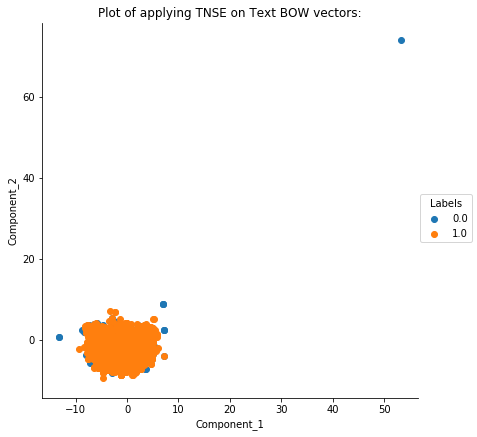

In [38]:
sns_plot = sns.FacetGrid(X_embedding_DF, hue="Labels", size=6).map(plt.scatter, "Component_1", "Component_2");
sns_plot.add_legend()
sns_plot
plt.title("Plot of applying TNSE on Text BOW vectors:")

## Bi-Gram, Tri-Gram and N-Gram

In [25]:
#bi-gram, tri-gram and n-gram

#Load the Count Vectorizer to extract uni-gram and bi-gram
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


In [40]:
final_bigram_counts_alt = pd.SparseDataFrame(final_bigram_counts)
print(final_bigram_counts_alt[:1])
print(type(final_bigram_counts_alt))

#using fillna() method to replace NaN with '0'
final_bigram_counts_alt_rem_NaN = final_counts_alt.fillna(0)

#printing starting two rows
print(final_bigram_counts_alt_rem_NaN[:1])

   0     1     2     3     4     5     6     7     8     9     ...   3134  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   

   3135  3136  3137  3138  3139  3140  3141  3142  3143  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[1 rows x 3144 columns]
<class 'pandas.core.sparse.frame.SparseDataFrame'>
   0      1      2      3      4      5      6      7      8      9      \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   ...    12987  12988  12989  12990  12991  12992  12993  12994  12995  12996  
0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[1 rows x 12997 columns]


In [43]:
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)

In [47]:
#final_bigram_counts_alt_rem_NaN = final_bigram_counts_alt_rem_NaN[:1000]

final_bigram_counts_alt_rem_NaN.shape
No_of_DataPoints = 2200;
final_bigram_counts_alt_rem_NaN = final_bigram_counts_alt_rem_NaN[:No_of_DataPoints]
%time

Wall time: 0 ns


In [55]:
#Fit and transform 
X_embedding = tsne.fit_transform(final_counts_alt_rem_NaN)
%time

Wall time: 0 ns


In [62]:
Y_type_Pos_or_Neg = final['Score']
Y_type_Pos_or_Neg = Y_type_Pos_or_Neg[:2300]
X_embedding.shape

(2300, 2)

In [63]:
X_embedding = np.hstack((X_embedding, Y_type_Pos_or_Neg.values.reshape(-1,1)))

In [64]:
X_embedding_DF = pd.DataFrame(data=X_embedding, columns=("Component_1", "Component_2", "Labels"));
print("The shape of X_embedding as dataframe is:",X_embedding_DF.shape);

The shape of X_embedding as dataframe is: (2300, 3)


Text(0.5,1,'Plot of applying TNSE on Text BOW vectors - BiGram:')

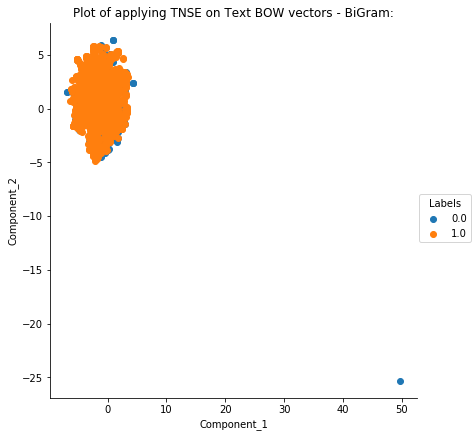

In [66]:
sns_plot = sns.FacetGrid(X_embedding_DF, hue="Labels", size=6).map(plt.scatter, "Component_1", "Component_2");
sns_plot.add_legend()
sns_plot
plt.title("Plot of applying TNSE on Text BOW vectors - BiGram:")

## [5.1] Applying TNSE on Text TFIDF vectors

In [24]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

#Load the TF-IDF vectorizer
TfIdf_Vect = TfidfVectorizer(ngram_range=(1,2));

In [25]:
TfIdf_Res_FitTrans = TfIdf_Vect.fit_transform(preprocessed_reviews);

In [26]:
#Let's load TSNE model
from sklearn.manifold import TSNE
Tsne_For_tfIdf = TSNE(n_components=2, perplexity=50, learning_rate=200);

In [27]:
Tsne_For_tfIdf

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=50,
   random_state=None, verbose=0)

In [28]:
TfIdf_Res_FitTrans_Converted = TfIdf_Res_FitTrans[:,:].toarray()
print(TfIdf_Res_FitTrans_Converted.shape)
no_of_Datapoints = 2000;
TfIdf_Res_FitTrans_Converted = TfIdf_Res_FitTrans_Converted[:no_of_Datapoints,:]
TfIdf_Res_FitTrans_Converted.shape

(4986, 137837)


(2000, 137837)

In [29]:
Tsne_Res_of_tfIdf = Tsne_For_tfIdf.fit_transform(TfIdf_Res_FitTrans_Converted)

In [30]:
Y_type_Pos_or_Neg = final['Score']
#Y_type_Pos_or_Neg = Y_type_Pos_or_Neg
#Y_type_Pos_or_Neg = Y_type_Pos_or_Neg[:500,:]
Y_type_Pos_or_Neg = Y_type_Pos_or_Neg[:no_of_Datapoints]

In [31]:

Tsne_Res_of_tfIdf = np.hstack((Tsne_Res_of_tfIdf, Y_type_Pos_or_Neg.values.reshape(-1,1)))

In [34]:
Tsne_Res_of_tfIdf_DF = pd.DataFrame(data=Tsne_Res_of_tfIdf, columns=("Component_1", "Component_2", "Labels"));
print("The shape of dataframe is:",Tsne_Res_of_tfIdf_DF.shape);

The shape of dataframe is: (2000, 3)


Text(0.5,1,'Plot of applying TNSE on Text TFIDF vectors - Uni/BiGram:')

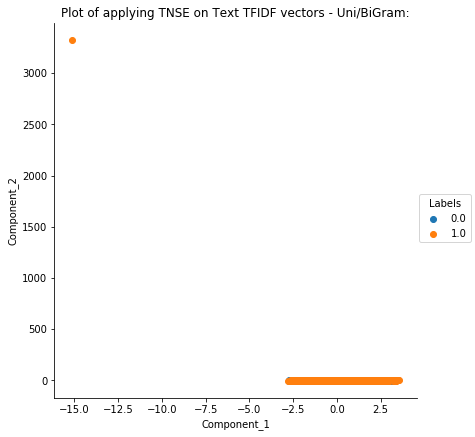

In [35]:
sns_plot = sns.FacetGrid(Tsne_Res_of_tfIdf_DF, hue="Labels", size=6).map(plt.scatter, "Component_1", "Component_2");
sns_plot.add_legend()
sns_plot
plt.title("Plot of applying TNSE on Text TFIDF vectors - Uni/BiGram:")

## [5.3] Applying TNSE on Text Avg W2V vectors

In [34]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

#To train own word2Vec model
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [36]:
list_of_sentance_50 =  list_of_sentance[0:50]

In [37]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

In [40]:
w2v_model_with_50 = Word2Vec(list_of_sentance_50,min_count=5,size=50, workers=4)

In [43]:
w2v_model.similar_by_word("dog")
w2v_words = list(w2v_model.wv.vocab)

In [45]:
tot_cnt=0
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            tot_cnt +=1
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))

100%|█████████████████████████████████████| 4986/4986 [00:06<00:00, 790.24it/s]


4986


In [67]:
#converting list to array
Arr_of_Sent_Vectors = np.asarray(sent_vectors)

In [75]:
#Steps
# 1. Load the TSNE model
# 2. 
tsne_model_for_Avg_W2V = TSNE(n_components=2, perplexity=50, learning_rate=200);
Tsne_of_Avg_W2V_data = tsne_model_for_Avg_W2V.fit_transform(Arr_of_Sent_Vectors)

In [77]:
Y_type_Pos_or_Neg = final['Score']
Y_type_Pos_or_Neg.shape

#appending class labels with TSNEd data of sentence vectors
Tsne_model_for_Avg_W2V = np.hstack((Tsne_of_Avg_W2V_data, Y_type_Pos_or_Neg.values.reshape(-1,1)))

In [78]:
Tsne_model_for_Avg_W2V = pd.DataFrame(data=Tsne_model_for_Avg_W2V, columns=("Component_1", "Component_2", "Labels"));
print("The shape of dataframe is:",Tsne_model_for_Avg_W2V.shape);

The shape of dataframe is: (4986, 3)


Text(0.5,1,'Plot of applying TNSE on Average Word2Vec data:')

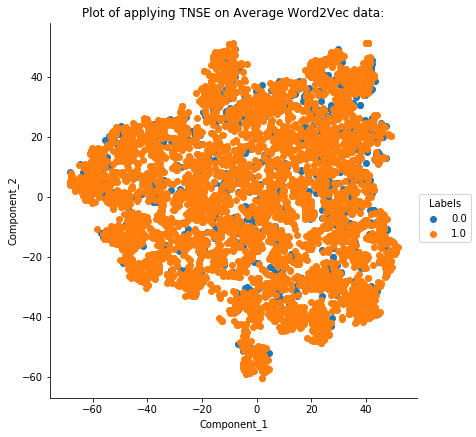

In [80]:
sns_plot = sns.FacetGrid(Tsne_model_for_Avg_W2V, hue="Labels", size=6).map(plt.scatter, "Component_1", "Component_2");
sns_plot.add_legend()
sns_plot
plt.title("Plot of applying TNSE on Average Word2Vec data:")

In [44]:
#this function would annotate the datapoints:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

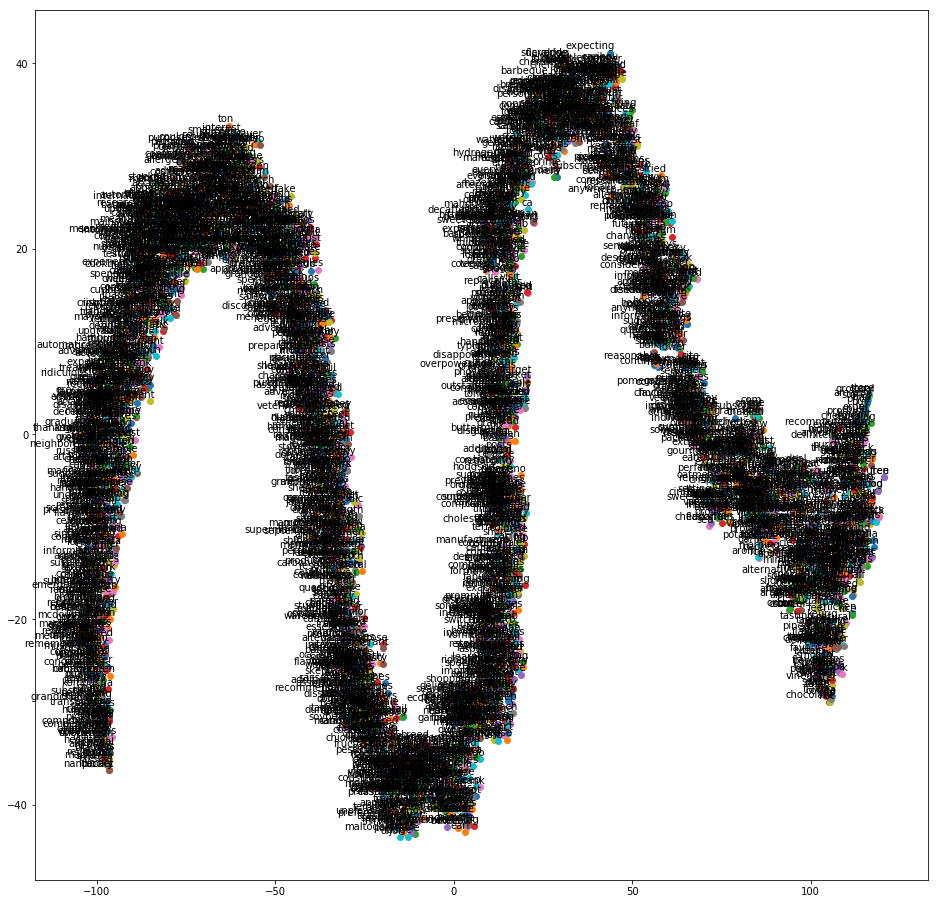

In [62]:
tsne_plot(w2v_model)

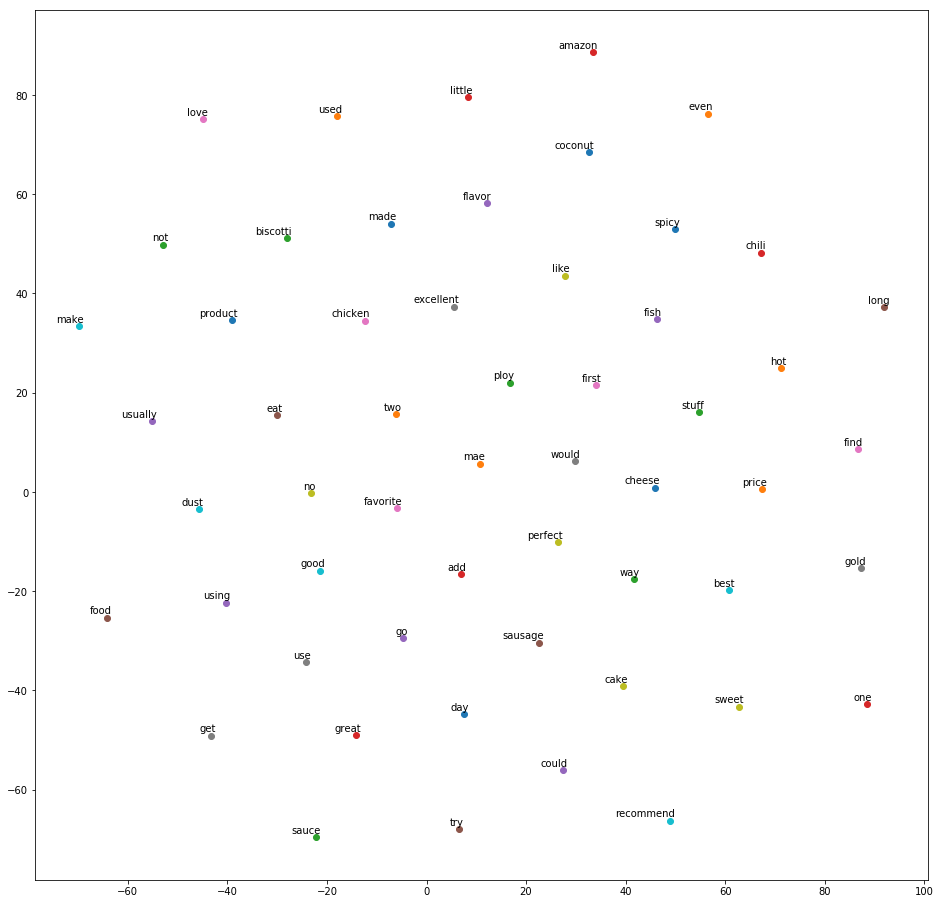

In [67]:
tsne_plot(w2v_model_with_50)

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

In [50]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
TfidfVectrzr = TfidfVectorizer()
TfidfVectrzr.fit(preprocessed_reviews)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(TfidfVectrzr.get_feature_names(), list(TfidfVectrzr.idf_)))


In [51]:
# TF-IDF weighted Word2Vec
tfidf_feat = TfidfVectrzr.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 4986/4986 [00:32<00:00, 151.52it/s]


In [60]:
Arr_of_tfidf_sent_vectors = np.asarray(tfidf_sent_vectors);

In [53]:
from sklearn.manifold import TSNE
Tsne_model_for_tfidf_W2v = TSNE()

In [61]:
No_Of_DataPoints = 2000;

In [62]:
Data_of_Tsned_tfidf_sent_vectors = Tsne_model_for_tfidf_W2v.fit_transform(Arr_of_tfidf_sent_vectors[0:No_Of_DataPoints])

In [63]:
Y_type_Pos_or_Neg = final['Score']
Y_type_Pos_or_Neg.shape

#appending class labels with TSNEd data of sentence vectors
Data_of_Tsned_tfidf_sent_vectors = np.hstack((Data_of_Tsned_tfidf_sent_vectors, Y_type_Pos_or_Neg[0:No_Of_DataPoints].values.reshape(-1,1)))

In [64]:
Data_of_Tsned_tfidf_sent_vectors[:5]

array([[ 35.32489777,  -9.98680496,   1.        ],
       [ 19.06433487,  11.37056446,   1.        ],
       [ 52.37245941, -24.79984856,   1.        ],
       [ 62.97787094, -34.3200264 ,   1.        ],
       [ 50.04372406, -21.88937569,   1.        ]])

In [65]:
Data_of_Tsned_tfidf_sent_vectors = pd.DataFrame(data=Data_of_Tsned_tfidf_sent_vectors, columns=("Component_1", "Component_2", "Labels"));
print("The shape of dataframe is:",Data_of_Tsned_tfidf_sent_vectors.shape);

The shape of dataframe is: (2000, 3)


Text(0.5,1,'Plot of applying TNSE on Weighted Word2Vec data:')

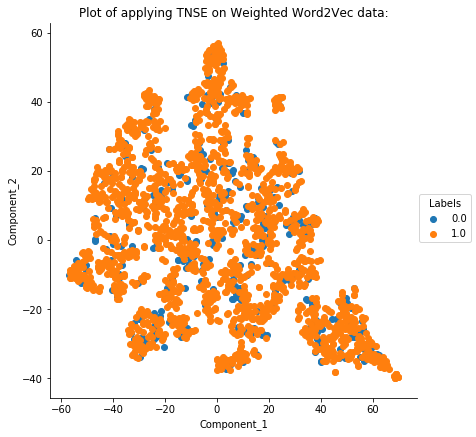

In [66]:
sns_plot = sns.FacetGrid(Data_of_Tsned_tfidf_sent_vectors, hue="Labels", size=6).map(plt.scatter, "Component_1", "Component_2");
sns_plot.add_legend()
sns_plot
plt.title("Plot of applying TNSE on Weighted Word2Vec data:")

# [6] Conclusions

1. Using TSNE we can reduce dimension of the dataset to required no. of components (=2 here).
2. For the given dataset more overlapping can be observed